In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import chardet
from IPython.display import Markdown

plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

In [2]:
os.listdir('.')

['.gitignore',
 'gun_violence_eda.ipynb',
 '.ipynb_checkpoints',
 'gun-violence-data_01-2013_03-2018.csv',
 '.git']

In [3]:
# check what the character encoding might be
with open('gun-violence-data_01-2013_03-2018.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'utf-8', 'language': '', 'confidence': 0.99}


In [4]:
df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv', index_col='incident_id', parse_dates=[1])

In [5]:
 df.columns

Index(['date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured',
       'incident_url', 'source_url', 'incident_url_fields_missing',
       'congressional_district', 'gun_stolen', 'gun_type',
       'incident_characteristics', 'latitude', 'location_description',
       'longitude', 'n_guns_involved', 'notes', 'participant_age',
       'participant_age_group', 'participant_gender', 'participant_name',
       'participant_relationship', 'participant_status', 'participant_type',
       'sources', 'state_house_district', 'state_senate_district'],
      dtype='object')

In [6]:
# removing unuseful columns 
df.drop(labels=['address', 'incident_url', 'incident_url_fields_missing', 'congressional_district',
                'location_description', 'participant_name', 'sources', 'state_house_district', 
                'state_senate_district', 'participant_age_group', 'notes', 'participant_relationship', 
                'gun_stolen'], 
        axis=1, inplace=True)

In [7]:
df.dtypes

date                        datetime64[ns]
state                               object
city_or_county                      object
n_killed                             int64
n_injured                            int64
source_url                          object
gun_type                            object
incident_characteristics            object
latitude                           float64
longitude                          float64
n_guns_involved                    float64
participant_age                     object
participant_gender                  object
participant_status                  object
participant_type                    object
dtype: object

# Plot map of incidents

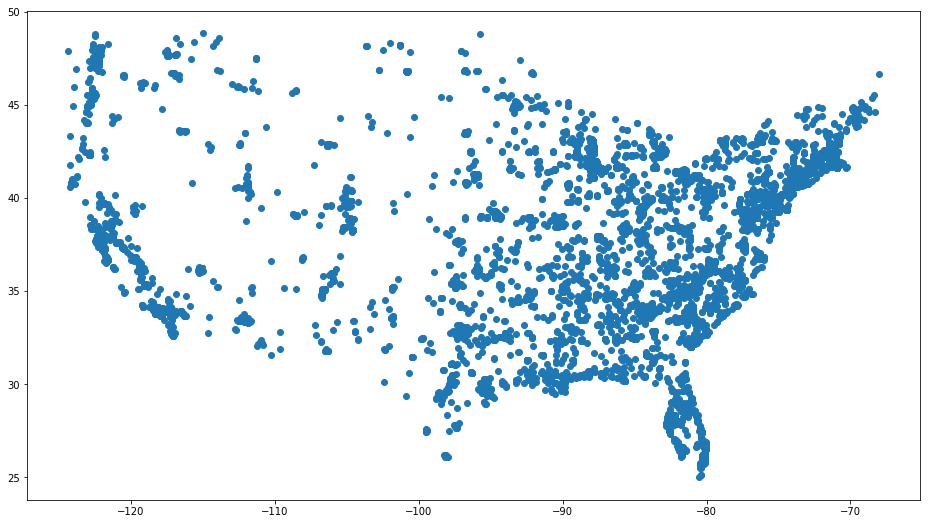

In [8]:
temp = df[['latitude', 'longitude']].copy()

# removing hawaii, alyeska and some anomalys
temp = temp.loc[temp['longitude'].between(-125, -40) & temp['latitude'].between(25, 50), :]
temp = temp.dropna().sample(10000)
plt.figure(figsize=(16, 9))
plt.scatter(temp['longitude'], temp['latitude']);

# Major facts about our dataset

In [9]:
total_incidents = df.shape[0]
zero_killed_or_injured = df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0)].shape[0]

Markdown("""
### In {} thousand incidents there is {:2.0f}% injured or killed people.
""".format(total_incidents // 1000, (total_incidents - zero_killed_or_injured) * 100 / total_incidents))


### In 239 thousand incidents there is 59% injured or killed people.


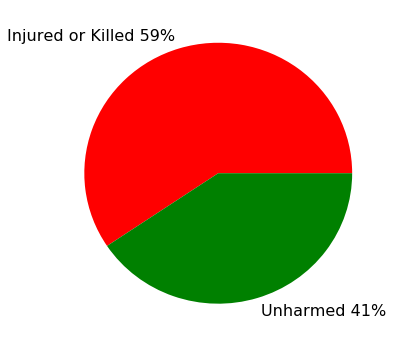

In [10]:
plt.figure(figsize=(6, 6))
patches, texts = plt.pie([total_incidents - zero_killed_or_injured, zero_killed_or_injured], 
                                     labels=['Injured or Killed 59%', 'Unharmed 41%'], colors=['r', 'g'])
texts[0].set_fontsize(16)
texts[1].set_fontsize(16)

In [11]:
df[['n_killed', 'n_injured']].describe()

,n_killed,n_injured
count,239677.000000,239677.000000
mean,0.252290,0.494007
std,0.521779,0.729952
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,50.000000,53.000000


In [12]:
temp = df['n_killed'].value_counts()\
.reset_index().rename(columns={'index': 'n_killed', 'n_killed': 'count'}).sort_values(by='n_killed')
temp['freq'] = temp['count'] / total_incidents
temp.loc[temp['freq'] >= 0.0001, ['n_killed', 'freq']]

,n_killed,freq
0,0,0.775356
1,1,0.202089
2,2,0.019209
3,3,0.002483
4,4,0.000580
5,5,0.000171


In [13]:
Markdown("""
### We can see what mass shooting (more or equal than 4 killed) is rare event it happend 1 in {:.0f} inidents
""".format( 1 / temp.loc[temp['n_killed'] >= 4, 'freq'].sum()))


### We can see what mass shooting (more or equal than 4 killed) is rare event it happend 1 in 1158 inidents


In [14]:
temp = (df['n_injured'] + df['n_killed']).value_counts().reset_index()\
.rename(columns={'index': 'n_injured_or_killed', 0: 'count'}).sort_values(by='n_injured_or_killed')
temp['freq'] = temp['count'] / total_incidents
temp.loc[temp['freq'] >= 0.001, ['n_injured_or_killed', 'freq']]

,n_injured_or_killed,freq
1,0,0.405909
0,1,0.484936
2,2,0.082586
3,3,0.017799
4,4,0.005591
5,5,0.001807


In [15]:
Markdown("""
### We can see what the most probable situation is where zero or one person injured or killed. \
Over {:.2f}% of all insidents have less or equal than 2 injured or killed person.
""".format(temp.loc[temp['n_injured_or_killed'] <= 2, 'freq'].sum()))


### We can see what the most probable situation is where zero or one person injured or killed. Over 0.97% of all insidents have less or equal than 2 injured or killed person.


In [16]:
df['date'].dt.year.value_counts()

2017    61401
2016    58763
2015    53579
2014    51854
2018    13802
2013      278
Name: date, dtype: int64

### It seems what amout of cases with guns increasing (if we drop 2013, 2018 because we don't have full data on them)

In [17]:
df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0), 'date'].dt.year.value_counts()

2017    24272
2014    23700
2016    22224
2015    21121
2018     5970
Name: date, dtype: int64

In [18]:
df.loc[~((df['n_killed'] == 0) & (df['n_injured']  == 0)), 'date'].dt.year.value_counts()

2017    37129
2016    36539
2015    32458
2014    28154
2018     7832
2013      278
Name: date, dtype: int64

### Amout of cases with injured people is also increasing

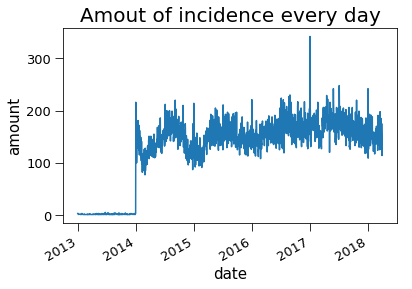

In [19]:
ax = df.groupby(by='date')['state'].count().plot()
ax.set_ylabel('amount', fontdict={'fontsize': 15})
ax.set_xlabel('date', fontdict={'fontsize': 15})
ax.tick_params(labelsize=13, length=8)
text = plt.title('Amout of incidence every day')
text.set_fontsize(20)

### 2013 is almost empty and should be ignored.

In [20]:
df.drop(df.loc[df['date'].dt.year == 2013].index, axis=0, inplace=True)

In [21]:
for year in range(2014, 2019):
    print('In {} {} unique websites were used'\
          .format(year, df.loc[df['date'].dt.year == year, 'source_url']\
                  .str.split('//').str.get(1).str.replace('^www.','').str.split('/').str.get(0).nunique()))

In 2014 2001 unique websites were used
In 2015 1900 unique websites were used
In 2016 2197 unique websites were used
In 2017 2429 unique websites were used
In 2018 1450 unique websites were used


In [22]:
for year in range(2014, 2019):
    print('In {} {} websites with more than 1 incident are used'\
          .format(year, (df.loc[df['date'].dt.year == year, 'source_url'].str.split('//')\
                  .str.get(1).str.replace('www.','').str.split('/').str.get(0)\
                  .value_counts() > 1).sum()))

In 2014 1310 websites with more than 1 incident are used
In 2015 1256 websites with more than 1 incident are used
In 2016 1515 websites with more than 1 incident are used
In 2017 1715 websites with more than 1 incident are used
In 2018 1026 websites with more than 1 incident are used


### We can see that amount of website where data is found is also increasing with time. 

In [23]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([2001, 1900, 2197, 2429])
stats.pearsonr(amount, year)

(0.9286527706898371, 0.07134722931016292)

In [24]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([1310, 1256, 1515, 1715])
stats.pearsonr(amount, year)

(0.9534795845489521, 0.046520415451047896)

### In both cases they highly correlated. But it doesn't mean that increasing of gun involved incidents can be explained by increasing of data sources.

# Work on participant features

In [25]:
df.dtypes

date                        datetime64[ns]
state                               object
city_or_county                      object
n_killed                             int64
n_injured                            int64
source_url                          object
gun_type                            object
incident_characteristics            object
latitude                           float64
longitude                          float64
n_guns_involved                    float64
participant_age                     object
participant_gender                  object
participant_status                  object
participant_type                    object
dtype: object

In [26]:
for i in range(6):
    print('Part of incident with atleast {1} person involved is {0}'.format(round(df['participant_age'].str.split('\|+').str.get(i).str.replace('[\d]*:+', '').notna().sum()\
    / df['participant_age'].notna().sum(), 2), i+1))

Part of incident with atleast 1 person involved is 1.0
Part of incident with atleast 2 person involved is 0.34
Part of incident with atleast 3 person involved is 0.1
Part of incident with atleast 4 person involved is 0.03
Part of incident with atleast 5 person involved is 0.01
Part of incident with atleast 6 person involved is 0.0


In [27]:
# n_people is amount of people we try to extract from participant's features
# n_people = 5 is 97% of dataset
n_people = 5
for person_number in range(n_people):
    df['age_{}'.format(person_number)] = df['participant_age'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['gender_{}'.format(person_number)] = df['participant_gender'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')

In [28]:
df['age_0'].dropna().astype('int').max(), df['age_0'].dropna().astype('int').min()

(311, 0)

In [29]:
# put restriction on age: 0 <= age <= 100
for person_number in range(n_people):
    df.loc[df['age_{}'.format(person_number)].astype('float') >= 100, 'age_{}'.format(person_number)] = 100
    df.loc[df['age_{}'.format(person_number)].astype('float') <= 0, 'age_{}'.format(person_number)] = 0

In [30]:
df['gender_0'].dropna().value_counts()

Male            177745
Female           25308
Male, female         1
Name: gender_0, dtype: int64

In [31]:
# put restriction on gender: gender is Male or Female
for person_number in range(n_people):
    df.loc[~df['gender_{}'.format(person_number)]\
           .isin(['Male', 'Female', np.NAN]), 'gender_{}'.format(person_number)] = 'Male'

In [32]:
list_noncense = ['Killed, Arrested', 'Injured, Unharmed', 'Injured, Unharmed, Arrested', 'Killed, Unharmed',
                 'Killed, Injured', 'Killed, Unharmed, Arrested']

In [33]:
for person_number in range(n_people):
    df['type_{}'.format(person_number)] = df['participant_type'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['status_{}'.format(person_number)] = df['participant_status'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')

In [34]:
for person_number in range(n_people):
    df.drop(df.loc[df['status_{}'.format(person_number)].isin(list_noncense)].index, axis=0, inplace=True)

In [35]:
# Work on incident_characteristics feature 

# pat_one_location = '[O|o]ne location'
# pat_police = '[O|o]fficer|[P|p]olice'
# pat_bar = '[B|b]ar|[C|c]lub'
# pat_animal = '[A|a]nimal'
# pat_illegal = '[S|s]tolen|[I|i]llegally'

# df['one_location'] = df['incident_characteristics'].str.contains(pat_one_location)
# df['officer_involved'] = df['incident_characteristics'].str.contains(pat_police)
# df['bar_club'] = df['incident_characteristics'].str.contains(pat_bar)
# df['animal'] = df['incident_characteristics'].str.contains(pat_animal)
# df['illegal'] = df['incident_characteristics'].str.contains(pat_illegal)

# Appears what only small number of incident description are detalaized
# for i in range(20, 60):
#     print(df['incident_characteristics'].iloc[i])
#     print('_'*80)

# Work on gun_type and n_guns_involved features

In [36]:
(df['n_guns_involved'].value_counts() / df['n_guns_involved'].value_counts().sum()).head(3).sum()

0.9773100601351256

### Incidents with 3 or less gun involved are about 97% (not including NAN) of our dataset, so it is ok to extract information of this amount of gun from feature gun_type 

In [37]:
n_gun = 3
for gun in range(n_gun):
    df['gun_type_{}'.format(gun)] = df['gun_type'].str.split('\|*')\
    .str.get(gun).str.replace('[\d*]:+', '')

In [38]:
def freq_dict(df, feature_name='gun_type', n=n_gun):
    temp_dict = {}
    for gun in range(n):
        _ = df[feature_name + '_{}'.format(gun)].value_counts().to_dict()
        if len(temp_dict) == 0:
            temp_dict = _
        else:
            for (k, v) in _.items():
                if k in temp_dict:
                    temp_dict[k] += _[k]
                else:
                    temp_dict[k] = _[k] 
    return temp_dict

temp_dict = freq_dict(df)

In [39]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp

,freq
Unknown,105007
Handgun,20948
9mm,6174
Rifle,3594
Shotgun,3547
22 LR,3133
40 SW,2613
380 Auto,2316
45 Auto,2239
38 Spl,1748


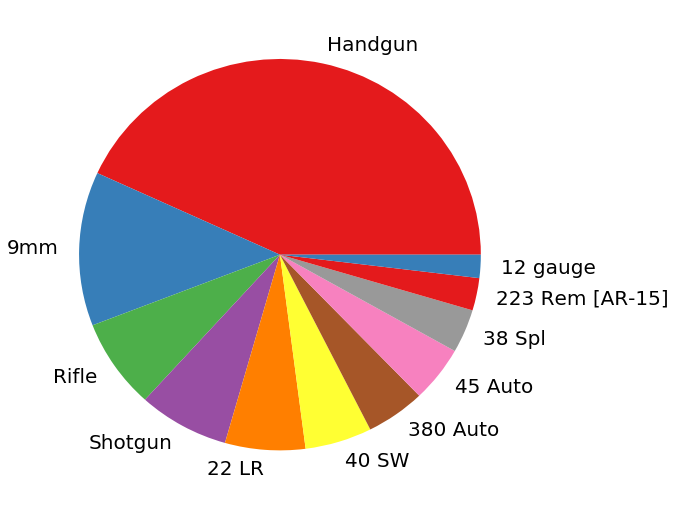

In [40]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp = temp.reset_index().head(12)
temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
plt.figure(figsize=(9, 9))
patches, texts = plt.pie(x=temp['freq'], labels=temp['index'], colors=plt.cm.Set1.colors[:temp['index'].shape[0]])

[text.set_fontsize(20) for text in texts];

### We can see what that most incidents is happened with handgun

In [41]:
# number of people who killed or injured
df['n_killed_injured'] = df['n_killed'] + df['n_injured']

In [42]:
amount_of_killed = 4
temp_list_with_dict_k = [freq_dict(df.loc[df['n_killed'] == i]) for i in range(amount_of_killed)] \
+ [freq_dict(df.loc[df['n_killed'] > amount_of_killed])]

temp_list_with_str_k = ['With {} dead | {} incidents'\
                      .format(i+1, df.loc[df['n_killed'] == i].shape[0]) for i in range(amount_of_killed)]\
+ ['With > {} dead | {} incidents'\
   .format(amount_of_killed, df.loc[df['n_killed'] == amount_of_killed].shape[0])] 


amount_of_injured = 4
temp_list_with_dict_i = [freq_dict(df.loc[df['n_injured'] == i]) for i in range(amount_of_injured)] \
+ [freq_dict(df.loc[df['n_injured'] > amount_of_injured])]

temp_list_with_str_i = ['With {} injured | {} incidents'\
                      .format(i+1, df.loc[df['n_injured'] == i].shape[0]) for i in range(amount_of_injured)]\
+ ['With > {} injured | {} incidents'\
   .format(amount_of_injured, df.loc[df['n_injured'] == amount_of_injured].shape[0])] 

n_casulties = 4
temp_list_with_dict_c = [freq_dict(df.loc[df['n_killed_injured'] == i]) for i in range(n_casulties)] \
+ [freq_dict(df.loc[df['n_killed_injured'] > n_casulties])]

temp_list_with_str_c = ['With {} killed or injured | {} incidents'\
                      .format(i+1, df.loc[df['n_killed_injured'] == i].shape[0]) for i in range(n_casulties)]\
+ ['With > {} killed or injured | {} incidents'\
   .format(n_casulties, df.loc[df['n_killed_injured'] == n_casulties].shape[0])] 

In [43]:
# map wepon to color
temp_dict = freq_dict(df)
temp_color = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp_color = temp_color.reset_index().head(21)
temp_color.drop(temp_color.loc[(temp_color['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
temp_color['color'] = (plt.cm.Set1.colors + plt.cm.Dark2.colors + plt.cm.tab10.colors)[:temp_color['index'].shape[0]]
temp_color.drop(['freq'], axis=1, inplace=True)

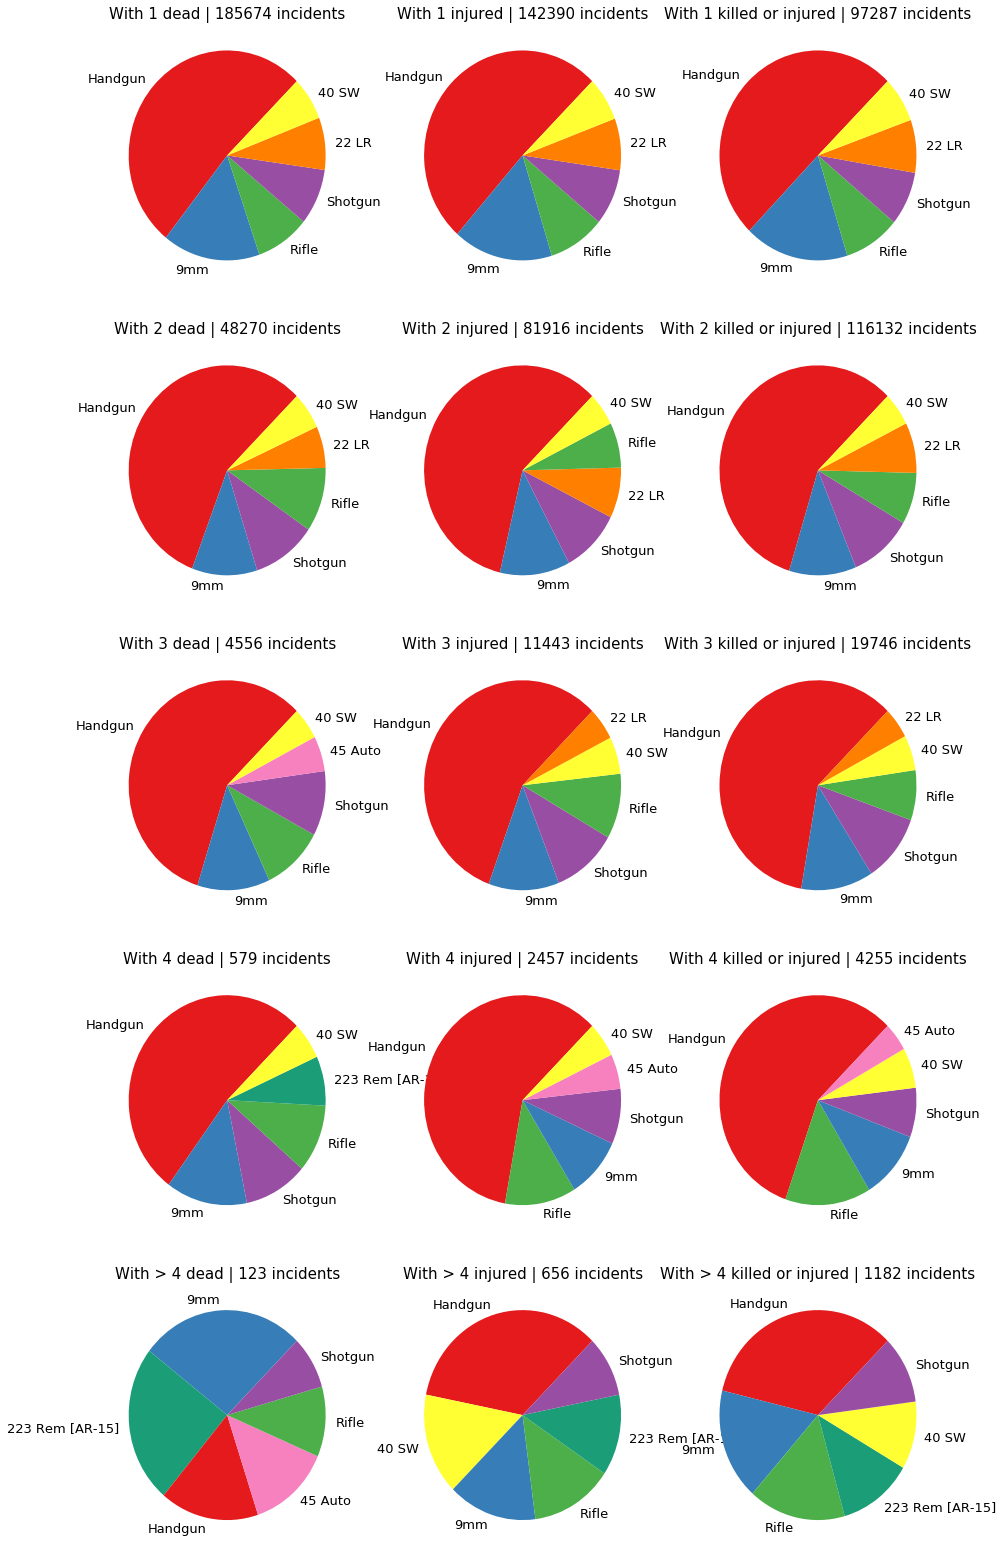

In [44]:
fig, ax = plt.subplots(len(temp_list_with_dict_k), 3)
fig.set_figheight(7 * amount_of_killed)
fig.set_figwidth(15)

for i, temp_dict in enumerate(temp_list_with_dict_k):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 0].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 0].set_title(temp_list_with_str_k[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_i):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 1].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 1].set_title(temp_list_with_str_i[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_c):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 2].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 2].set_title(temp_list_with_str_c[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];

### In mass shooting part of handgun is decreasing

In [45]:
# There are much more male than female
freq_dict(df, 'gender', 5)

{'Female': 42305, 'Male': 304648}

In [46]:
# ratio
304734 / 42234

7.215371501633755

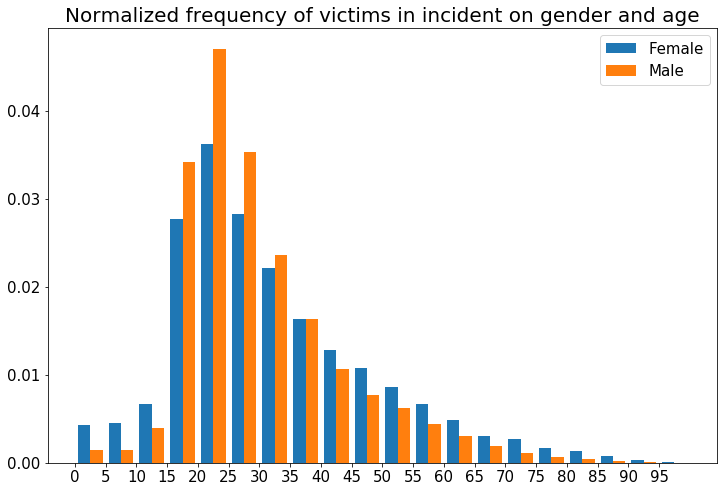

In [47]:
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
plt.hist([temp, temp2], bins=20, normed=True, label=['Female', 'Male']);
plt.legend(fontsize=15)
plt.title('Normalized frequency of victims in incident on gender and age', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, 100, step=5), fontsize=15);
plt.yticks(fontsize=15);

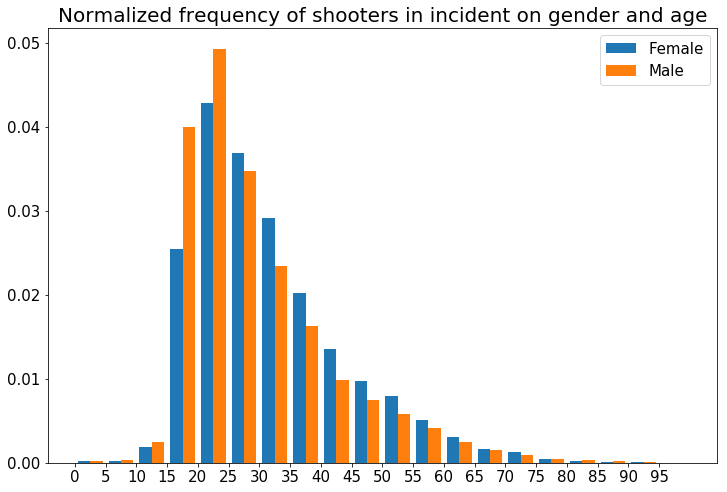

In [48]:
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
plt.hist([temp, temp2], bins=20, normed=True, label=['Female', 'Male']);
plt.legend(fontsize=15)
plt.title('Normalized frequency of shooters in incident on gender and age', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, 100, step=5), fontsize=15);
plt.yticks(fontsize=15);

### We can that there isn't any different between victims and shooters in age distribution. Also their mean age is almost the same and isn't depend on gender or role in incident.

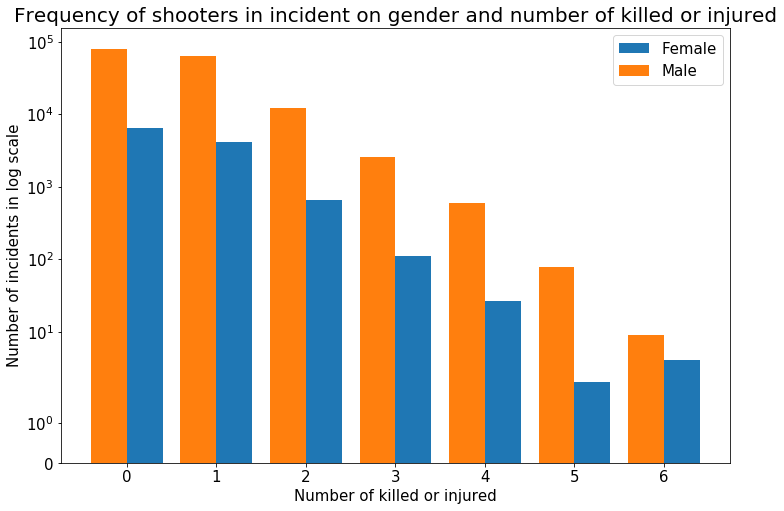

In [49]:
fig = plt.figure(figsize=(12, 8))
male =[]
female = []
n_k = 7
for k in range(n_k):
    temp = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect') & \
                       (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    temp2 = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect') & \
                    (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    female.append(temp)
    male.append(temp2)

plt.yscale('symlog', linthreshx=6.)
plt.bar(np.arange(n_k) + 0.2, female, width=0.4, label='Female')
plt.bar(np.arange(n_k) - 0.2, male, width=0.4, label='Male')
plt.legend(fontsize=15)
plt.title('Frequency of shooters in incident on gender and number of killed or injured', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, n_k, step=1), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of killed or injured', fontsize=15)
plt.ylabel('Number of incidents in log scale', fontsize=15);

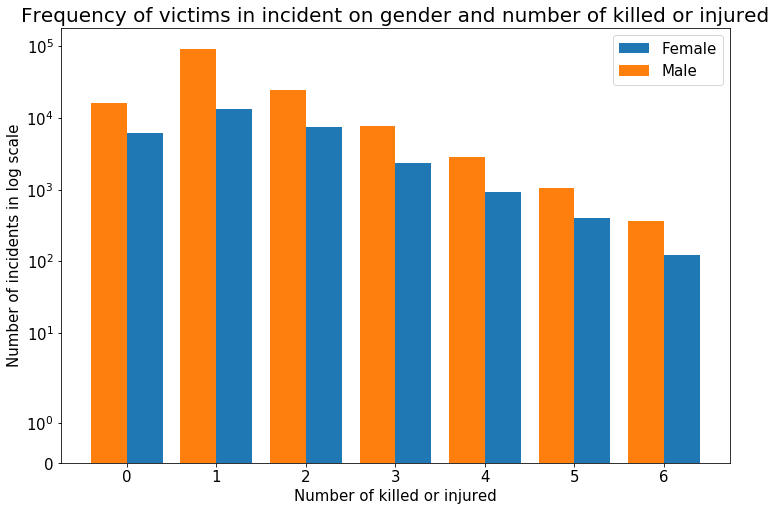

In [50]:
fig = plt.figure(figsize=(12, 8))
male =[]
female = []
n_k = 7
for k in range(n_k):
    temp = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim') & \
                       (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    temp2 = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim') & \
                    (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    female.append(temp)
    male.append(temp2)

plt.yscale('symlog', linthreshx=6.)
plt.bar(np.arange(n_k) + 0.2, female, width=0.4, label='Female')
plt.bar(np.arange(n_k) - 0.2, male, width=0.4, label='Male')
plt.legend(fontsize=15)
plt.title('Frequency of victims in incident on gender and number of killed or injured', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, n_k, step=1), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of killed or injured', fontsize=15)
plt.ylabel('Number of incidents in log scale', fontsize=15);
ax = fig.get_axes()[0]

In [51]:
df['status_0'].value_counts()

Injured               85770
Killed                50651
Unharmed, Arrested    35174
Unharmed              34428
Arrested               3819
Injured, Arrested      1789
Name: status_0, dtype: int64

In [52]:
status_k = ['Killed']
status_i = ['Injured', 'Injured, Arrested']
status_u = ['Unharmed, Arrested', 'Unharmed', 'Arrested']

In [53]:
temp_f_k_v = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim') & \
                         (df['status_%s' % i].isin(status_k)), 'n_killed_injured'].shape[0] for i in range(n_people)])
temp_m_k_v = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim') & \
                         (df['status_%s' % i].isin(status_k)), 'n_killed_injured'].shape[0] for i in range(n_people)])

temp_f_i_v = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim') & \
                         (df['status_%s' % i].isin(status_i)), 'n_killed_injured'].shape[0] for i in range(n_people)])
temp_m_i_v = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim') & \
                         (df['status_%s' % i].isin(status_i)), 'n_killed_injured'].shape[0] for i in range(n_people)])

temp_f_u_v = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim') & \
                         (df['status_%s' % i].isin(status_u)), 'n_killed_injured'].shape[0] for i in range(n_people)])
temp_m_u_v = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim') & \
                         (df['status_%s' % i].isin(status_u)), 'n_killed_injured'].shape[0] for i in range(n_people)])


temp_f_k_s = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect') & \
                         (df['status_%s' % i].isin(status_k)), 'n_killed_injured'].shape[0] for i in range(n_people)])
temp_m_k_s = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect') & \
                         (df['status_%s' % i].isin(status_k)), 'n_killed_injured'].shape[0] for i in range(n_people)])

temp_f_i_s = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect') & \
                         (df['status_%s' % i].isin(status_i)), 'n_killed_injured'].shape[0] for i in range(n_people)])
temp_m_i_s = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect') & \
                         (df['status_%s' % i].isin(status_i)), 'n_killed_injured'].shape[0] for i in range(n_people)])

temp_f_u_s = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect') & \
                         (df['status_%s' % i].isin(status_u)), 'n_killed_injured'].shape[0] for i in range(n_people)])
temp_m_u_s = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect') & \
                         (df['status_%s' % i].isin(status_u)), 'n_killed_injured'].shape[0] for i in range(n_people)])

In [54]:
l_f = [temp_f_k_v, temp_f_k_s, temp_f_i_v, temp_f_i_s, temp_f_u_v, temp_f_u_s]
f_max = max(l_f)

l_m = [temp_m_k_v, temp_m_k_s, temp_m_i_v, temp_m_i_s, temp_m_u_v, temp_m_u_s]
m_max = max(l_m)

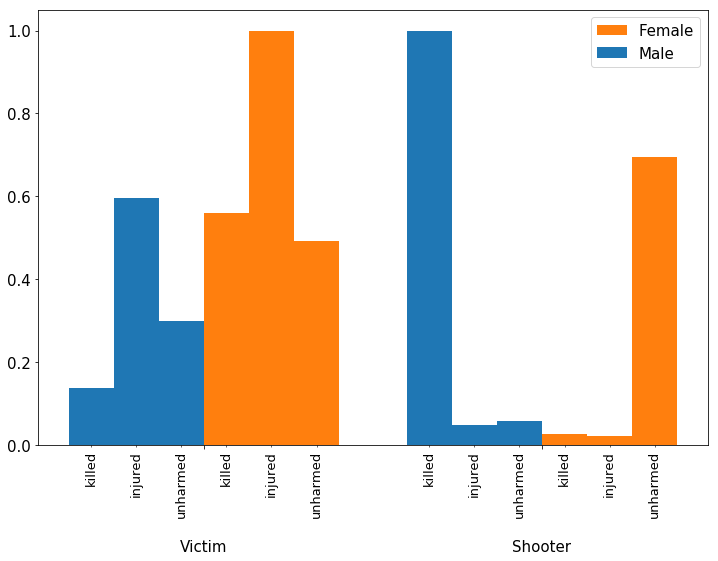

In [55]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
orange = (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

fig = plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 6, 3) + 0.2, [temp_f_k_v / f_max, temp_f_k_s / f_max], width=0.4, label='Female', color=orange)
plt.bar(np.arange(0, 6, 3) + 0.6, [temp_f_i_v / f_max, temp_f_i_s / f_max], width=0.4, color=orange)
plt.bar(np.arange(0, 6, 3) + 1, [temp_f_u_v / f_max, temp_f_u_s / f_max], width=0.4, color=orange)

plt.bar(np.arange(0, 6, 3) - 0.2, [temp_m_k_v / m_max, temp_m_k_s / m_max], width=0.4, label='Male', color=blue)
plt.bar(np.arange(0, 6, 3) - 0.6, [temp_m_i_v / m_max, temp_m_i_s / m_max], width=0.4, color=blue)
plt.bar(np.arange(0, 6, 3) - 1, [temp_m_u_v / m_max, temp_m_u_s / m_max], width=0.4, color=blue)

plt.legend(fontsize=15)
ax = fig.get_axes()[0]
ax.xaxis.set_minor_locator(ticker.FixedLocator(([-1, -0.6, -0.2, 0.2, 0.6, 1, 2, 2.4, 2.8, 3.2, 3.6, 4])))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter((['killed', 'injured', 'unharmed'] * 4)))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=13)

ax.xaxis.set_major_locator(ticker.FixedLocator(([0, 3])))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((['Victim', 'Shooter'])))
ax.xaxis.get_majorticklabels()[0].set_position((0, -0.2))
ax.xaxis.get_majorticklabels()[1].set_position((3, -0.2))
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15)
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15);

### We can see that distribution between gender is pretty different, especially in role of shooter.